In [59]:
import numpy as np
try:
    import itertools.izip as zip
except ImportError:
    import itertools

### Parameters

In [60]:
pop_size = 100
alphabet = ['0', '1']
seq_length = 1

base_haplotype = "0"
fraction_base = 0.5

fitness_nodrug = {'base': 1.5, 'resistant': 1, 'fusion': 1.25}
fitness_drug = {'base': 0.5, 'resistant': 1.0, 'fusion': 1.25}

fitness_base = fitness_nodrug['base']
fitness_resistant = fitness_nodrug['resistant']
fitness_fusion = fitness_nodrug['fusion']

fitness_effect = 1.5 # fitness effect if a functional mutation occurs
fitness_chance = 0.01 # chance that a mutation has a fitness effect

mutation_rate = 0.005
fitness_rate = 0.01
fusion_rate = 0.05


### Population

In [61]:
pop = {}
pop["0"] = pop_size * fraction_base
pop["1"] = pop_size * (1 - fraction_base)

print("Starting population: {}".format(pop))

fitness = {}
fitness["0"] = fitness_base
fitness["1"] = fitness_resistant

print("Fitness: {}".format(fitness))

def get_random_haplotype():
    """Returns a random haplotype from the population, weighted by the frequency of the haplotype"""
    haplotypes = list(pop.keys()) 
    frequencies = [x/float(pop_size) for x in pop.values()]
    total = sum(frequencies)
    frequencies = [x / total for x in frequencies]
    return np.random.choice(haplotypes, p=frequencies)

def update_fitness(haplotype):
    old_fitness = fitness[haplotype]
    if (np.random.random() < fitness_chance):
        return old_fitness * fitness_effect
    else:
        return old_fitness


Starting population: {'0': 50.0, '1': 50.0}
Fitness: {'0': 1.5, '1': 1}


### Mutation

In [62]:
def get_mutation_count():
    mean = mutation_rate * pop_size * seq_length
    return np.random.poisson(mean)

def make_mutant(haplotype):
    site = np.random.randint(seq_length)
    possible_mutations = list(alphabet)
    possible_mutations.remove(haplotype[site])
    mutation = np.random.choice(possible_mutations)
    new_haplotype = haplotype[:site] + mutation + haplotype[site+1:]
    return new_haplotype    

def get_mutant_fitness(haplotype):
    old_fitness = fitness[haplotype]
    if (np.random.random() < fitness_chance):
        return old_fitness * fitness_effect
    else:
        return old_fitness

def mutation_event():
    haplotype = get_random_haplotype()
    if pop[haplotype] > 1:
        pop[haplotype] -= 1
        new_haplotype = make_mutant(haplotype)
        if new_haplotype in pop:
            pop[new_haplotype] += 1
        else:
            pop[new_haplotype] = 1
        if new_haplotype not in fitness:
            fitness[new_haplotype] = get_mutant_fitness(haplotype)

def mutation_step():
    mutation_count = get_mutation_count()
    for i in range(mutation_count):
        mutation_event()

### Fusion

In [63]:
def get_fusion_count():
    mean = fusion_rate * pop_size
    return np.random.poisson(mean)

def make_fusion(hap1, hap2):
    fused = hap1 + hap2
    return ''.join(sorted(fused))

def get_fusion_fitness(haplotype):
    from math import e
    
    length = len(haplotype)

    # Don't let the haplotype go past 2 chars.
    if length > 2:
        return 0

    # Use a Gaussian function such that the fitness is lower when very short and very long.
    # f(x) = ae^(-(x-b)^2/2c^2)
    a = fitness_fusion * 0.9
    b = 4 # max fitness at length 8
    c = 16 # stdev
    
    fitness = a * e ** (-1 * ((length - b) ** 2) / ((2 * c) ** 2))
    return fitness

def fusion_event():
    hap1 = get_random_haplotype()
    hap2 = get_random_haplotype()

    # Don't let the same haplotypes fuse.
    if hap1 == hap2:
        return
    
    # If fusion would remove either population of cells, don't let it happen.
    if pop[hap1] == 1 or pop[hap2] == 1:
        return


    pop[hap1] -= 1
    pop[hap2] -= 1

    new_haplotype = make_fusion(hap1, hap2)

    if new_haplotype in pop:
        pop[new_haplotype] += 1
    else:
        pop[new_haplotype] = 1
    if new_haplotype not in fitness:
        fitness[new_haplotype] = get_fusion_fitness(new_haplotype)

def fusion_step():
    fusion_count = get_fusion_count()
    for i in range(fusion_count):
        fusion_event()

### Offspring

In [64]:
def get_offspring_counts():
    haplotypes = list(pop.keys())
    frequencies = [pop[haplotype]/float(pop_size) for haplotype in haplotypes]
    fitnesses = [fitness[haplotype] for haplotype in haplotypes]
    weights = [x * y for x,y in zip(frequencies, fitnesses)]
    total = sum(weights)
    weights = [x / total for x in weights]
    return list(np.random.multinomial(pop_size, weights))

def offspring_step():
    haplotypes = list(pop.keys())
    counts = get_offspring_counts()
    for (haplotype, count) in zip(haplotypes, counts):
        if (count > 0):
            pop[haplotype] = count
        else:
            del pop[haplotype]

### Analysis

In [65]:
from Levenshtein import distance as levenshtein_distance

def get_distance(seq_a, seq_b):
    return levenshtein_distance(seq_a, seq_b)

def get_diversity(population):
    haplotypes = list(population.keys())
    haplotype_count = len(haplotypes)
    diversity = 0
    for i in range(haplotype_count):
        for j in range(haplotype_count):
            haplotype_a = haplotypes[i]
            haplotype_b = haplotypes[j]
            frequency_a = population[haplotype_a] / float(pop_size)
            frequency_b = population[haplotype_b] / float(pop_size)
            frequency_pair = frequency_a * frequency_b
            diversity += frequency_pair * get_distance(haplotype_a, haplotype_b)
    return diversity

def get_diversity_trajectory():
    trajectory = [get_diversity(generation) for generation in history]
    return trajectory

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

def diversity_plot():
    mpl.rcParams['font.size']=14
    trajectory = get_diversity_trajectory()
    plt.plot(trajectory, "#447CCD")    
    plt.ylabel("diversity")
    plt.xlabel("generation")

def get_divergence(population):
    haplotypes = population.keys()
    divergence = 0
    for haplotype in haplotypes:
        frequency = population[haplotype] / float(pop_size)
        divergence += frequency * get_distance(base_haplotype, haplotype)
    return divergence

def get_divergence_trajectory():
    trajectory = [get_divergence(generation) for generation in history]
    return trajectory

def divergence_plot():
    mpl.rcParams['font.size']=14
    trajectory = get_divergence_trajectory()
    plt.plot(trajectory, "#447CCD")
    plt.ylabel("divergence")
    plt.xlabel("generation") 

def get_frequency(haplotype, generation):
    pop_at_generation = history[generation]
    if haplotype in pop_at_generation:
        return pop_at_generation[haplotype]/float(pop_size)
    else:
        return 0
    
def get_trajectory(haplotype):
    trajectory = [get_frequency(haplotype, gen) for gen in range(generations)]
    return trajectory

def get_all_haplotypes():
    haplotypes = set()   
    for generation in history:
        for haplotype in generation:
            haplotypes.add(haplotype)
    return haplotypes

colors = ["#781C86", "#571EA2", "#462EB9", "#3F47C9", "#3F63CF", "#447CCD", "#4C90C0", "#56A0AE", "#63AC9A", "#72B485", "#83BA70", "#96BD60", "#AABD52", "#BDBB48", "#CEB541", "#DCAB3C", "#E49938", "#E68133", "#E4632E", "#DF4327", "#DB2122"]
colors_lighter = ["#A567AF", "#8F69C1", "#8474D1", "#7F85DB", "#7F97DF", "#82A8DD", "#88B5D5", "#8FC0C9", "#97C8BC", "#A1CDAD", "#ACD1A0", "#B9D395", "#C6D38C", "#D3D285", "#DECE81", "#E8C77D", "#EDBB7A", "#EEAB77", "#ED9773", "#EA816F", "#E76B6B"]

def stacked_trajectory_plot(xlabel="generation"):
    mpl.rcParams['font.size']=18
    haplotypes = get_all_haplotypes()
    trajectories = [get_trajectory(haplotype) for haplotype in haplotypes]
    plt.stackplot(range(generations), trajectories, colors=colors_lighter, labels=haplotypes)
    # plt.legend(bbox_to_anchor=(1.2, 1))
    plt.ylim(0, 1)
    plt.ylabel("frequency")
    plt.xlabel(xlabel)

def get_snp_frequency(site, generation):
    minor_allele_frequency = 0.0
    pop_at_generation = history[generation]
    for haplotype in pop_at_generation.keys():
        allele = haplotype[site]
        frequency = pop_at_generation[haplotype] / float(pop_size)
        if allele != "0":
            minor_allele_frequency += frequency
    return minor_allele_frequency

def get_snp_trajectory(site):
    trajectory = [get_snp_frequency(site, gen) for gen in range(generations)]
    return trajectory

def get_all_snps():
    snps = set()   
    for generation in history:
        for haplotype in generation:
            for site in range(seq_length):
                if haplotype[site] != "0":
                    snps.add(site)
    return snps

def snp_trajectory_plot(xlabel="generation"):
    mpl.rcParams['font.size']=18
    snps = get_all_snps()
    trajectories = [get_snp_trajectory(snp) for snp in snps]
    data = []
    for trajectory, color in zip(trajectories, itertools.cycle(colors)):
        data.append(range(generations))
        data.append(trajectory)    
        data.append(color)
    fig = plt.plot(*data)   
    plt.ylim(0, 1)
    plt.ylabel("frequency")
    plt.xlabel(xlabel)


### Drug

In [66]:
def set_drug(is_present):
    # TODO: Maybe don't use globals here? We can pass the drug state into the step functions.
    global fitness_base
    global fitness_resistant
    global fitness_fusion

    if is_present:
        fitness_base = fitness_drug['base']
        fitness_resistant = fitness_drug['resistant']
        fitness_fusion = fitness_drug['fusion']
    else:
        fitness_base = fitness_nodrug['base']
        fitness_resistant = fitness_nodrug['resistant']
        fitness_fusion = fitness_nodrug['fusion']
    
    fitness["0"] = fitness_base
    fitness["1"] = fitness_resistant
    haplotypes = list(pop.keys())
    for hap in haplotypes:
        if len(hap) < 2: continue
        fitness[hap] = get_fusion_fitness(hap)


### Simulation

{'0': 29, '1': 69, '01': 2}
{'0': 16, '1': 81, '01': 3}
{'0': 5, '1': 86, '01': 9}
{'0': 4, '1': 86, '01': 10}
{'0': 1, '1': 84, '01': 12, '11': 3}
{'1': 91, '01': 9}
{'1': 91, '01': 9}
{'1': 96, '01': 3, '0': 1}
{'1': 94, '01': 2, '0': 4}
{'1': 95, '01': 3, '0': 2}
{'1': 97, '01': 3}
{'1': 98, '01': 2}
{'1': 97, '01': 3}
{'1': 99, '0': 1}
{'1': 99, '0': 1}
{'1': 99, '0': 1}
{'1': 100}
{'1': 100}
{'1': 100}
{'1': 100}
{'1': 100}
{'1': 100}
{'1': 100}
{'1': 100}
{'1': 100}
{'1': 99, '0': 1}
{'1': 99, '0': 1}
{'1': 100}
{'1': 100}
{'1': 100}
{'1': 100}
{'1': 97, '0': 1, '01': 2}
{'1': 97, '0': 2, '01': 1}
{'1': 98, '01': 2}
{'1': 95, '01': 5}
{'1': 96, '01': 4}
{'1': 95, '01': 5}
{'1': 94, '01': 6}
{'1': 95, '01': 5}
{'1': 95, '01': 5}
{'1': 95, '01': 5}
{'1': 95, '01': 5}
{'1': 93, '01': 4, '0': 3}
{'1': 92, '01': 4, '0': 4}
{'1': 95, '01': 5}
{'1': 91, '01': 9}
{'1': 91, '01': 9}
{'1': 88, '01': 12}
{'1': 88, '01': 12}
{'1': 88, '01': 12}
{'1': 87, '01': 13}
{'1': 91, '01': 9}
{'1': 92

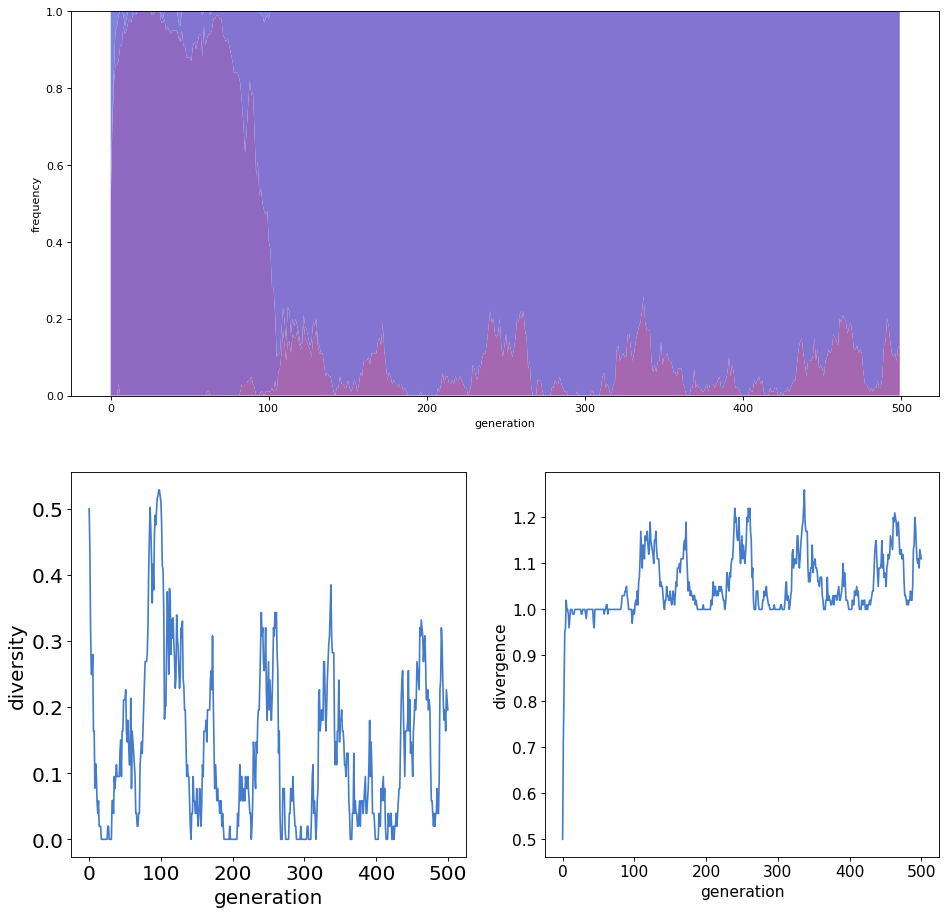

In [67]:
generations = 500
history = []

def time_step():
    mutation_step()
    fusion_step()
    offspring_step()

def simulate():
    set_drug(True)
    clone_pop = dict(pop)
    history.append(clone_pop)
    for i in range(generations):
        time_step()
        clone_pop = dict(pop)
        history.append(clone_pop)
        print(pop)

simulate()

plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.subplot2grid((2,2), (0,0), colspan=2)
stacked_trajectory_plot()
#plt.subplot2grid((3,2), (1,0), colspan=2)
#snp_trajectory_plot()
plt.subplot2grid((2,2), (1,0))
diversity_plot()
plt.subplot2grid((2,2), (1,1))
divergence_plot()
